In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load  dataset
dataset_path = '/content/BTC-USD.csv'  # Replace with the path to your dataset
btcdata = pd.read_csv(dataset_path, parse_dates=True, index_col='Date')
btcdata

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072
...,...,...,...,...,...,...
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,37138.234375,25041426629
2022-01-28,37128.445313,37952.878906,36211.109375,37784.332031,37784.332031,22238830523
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,38138.179688,17194183075


In [ ]:
# Transaction costs and slippage bt default considered
transaction_cost_rate = 0.0020  # 0.20%
slippage = 0.005  # 0.5%

In [ ]:
# Trend-Following Strategy
def trend_strategy(df, short_window=10, long_window=50):
    df1 = pd.DataFrame(index=df.index)
    df1['signal'] = 0.0

    # Create short simple moving average
    df1['short_mavg'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

    # Create long simple moving average
    df1['long_mavg'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    # Generate signals based on moving average crossover
    df1['signal'][short_window:] = np.where(df1['short_mavg'][short_window:] > df1['long_mavg'][short_window:], 1.0, -1.0)

    # Generate trading orders
    df1['positions'] = df1['signal'].diff()

    return df1

# Mean-Reversion Strategy
def meanreversion_strategy(df, lookback_period=20, z_score_threshold=1.0):
    df1 = pd.DataFrame(index=df.index)
    df1['signal'] = 0.0

    # Calculate the rolling mean and standard deviation
    rolling_mean = df['Close'].rolling(window=lookback_period).mean()
    rolling_std = df['Close'].rolling(window=lookback_period).std()

    # Calculate z-score
    z_score = (df['Close'] - rolling_mean) / rolling_std

    # Generate signals based on z-score
    df1['signal'][z_score < -z_score_threshold] = 1.0
    df1['signal'][z_score > z_score_threshold] = -1.0

    # Generate trading orders
    df1['positions'] = df1['signal'].diff()

    return df1
    # Momentum-Centric Strategy
def momentumcentric_strategy(df, short_window=50, long_window=200):
    df1 = pd.DataFrame(index=df.index)
    df1['signal'] = 0.0

    # Create short simple moving average
    df1['short_mavg'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

    # Create long simple moving average
    df1['long_mavg'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    # Generate signals based on moving average crossover
    df1['signal'][short_window:] = np.where(df1['short_mavg'][short_window:] > df1['long_mavg'][short_window:], 1.0, -1.0)

    # Generate trading orders
    df1['positions'] = df1['signal'].diff()

    return df1
## Machine Learning Approach
def machinelearning_strategy(df):
    df['SMA50'] = df['Close'].rolling(window=50).mean()
    df['SMA200'] = df['Close'].rolling(window=200).mean()
    df.dropna(inplace=True)

    df['Signal'] = np.where(df['SMA50'] > df['SMA200'], 1, -1)

    X = df[['SMA50', 'SMA200']]
    y = df['Signal']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)

    df1 = pd.DataFrame(index=X_test.index)
    df1['signal'] = np.where(y_pred == 1, 1.0, -1.0)

    df1['positions'] = df1['signal'].diff()

    # Evaluate the model on the training set
    training_accuracy = accuracy_score(y_train, clf.predict(X_train_scaled))
    print(f"Training Accuracy: {training_accuracy:.2%}")

    # Evaluate the model on the test set
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.2%}")

    return df1

In [ ]:
# Backtesting
def backtest_strategy(df, signals, transaction_cost_rate, slippage):
    capital = 100000  # Initial capital in USDT
    position = 0  # Initial position

    # find daily returns
    df['returns'] = df['Close'].pct_change()

    # Apply signals to generate trading orders
    df['positions'] = signals['positions']

    # Apply transaction costs and slippage
    df['positions'] = df['positions'].shift(1)  # Shift positions to avoid lookahead bias
    df['positions'].fillna(0, inplace=True)  # Fill NaN in the first row
    df['transaction_costs'] = abs(df['positions'] - df['positions'].shift(1)) * transaction_cost_rate
    df['slippage'] = abs(df['positions'] - df['positions'].shift(1)) * slippage

    # find  daily portfolio value
    df['portfolio_value'] = capital + (df['returns'] * capital * position) - df['transaction_costs'] - df['slippage']

    # find cumulative returns
    df['cumulative_returns'] = (1 + df['returns']).cumprod() - 1
    df['cumulative_portfolio_returns'] = (1 + df['returns'] * df['positions']).cumprod() - 1

    annual_returns = (df['cumulative_portfolio_returns'].iloc[-1] + 1) ** (252 / len(df.index)) - 1
    max_drawdown = -df['cumulative_portfolio_returns'].min()

    print(f'Annual Returns: {annual_returns * 100:.2f}%')
    print(f'Maximum Drawdown: {max_drawdown * 100:.2f}%\n')

    return df, annual_returns, max_drawdown

Annual Returns: 17.43%
Maximum Drawdown: -0.00%



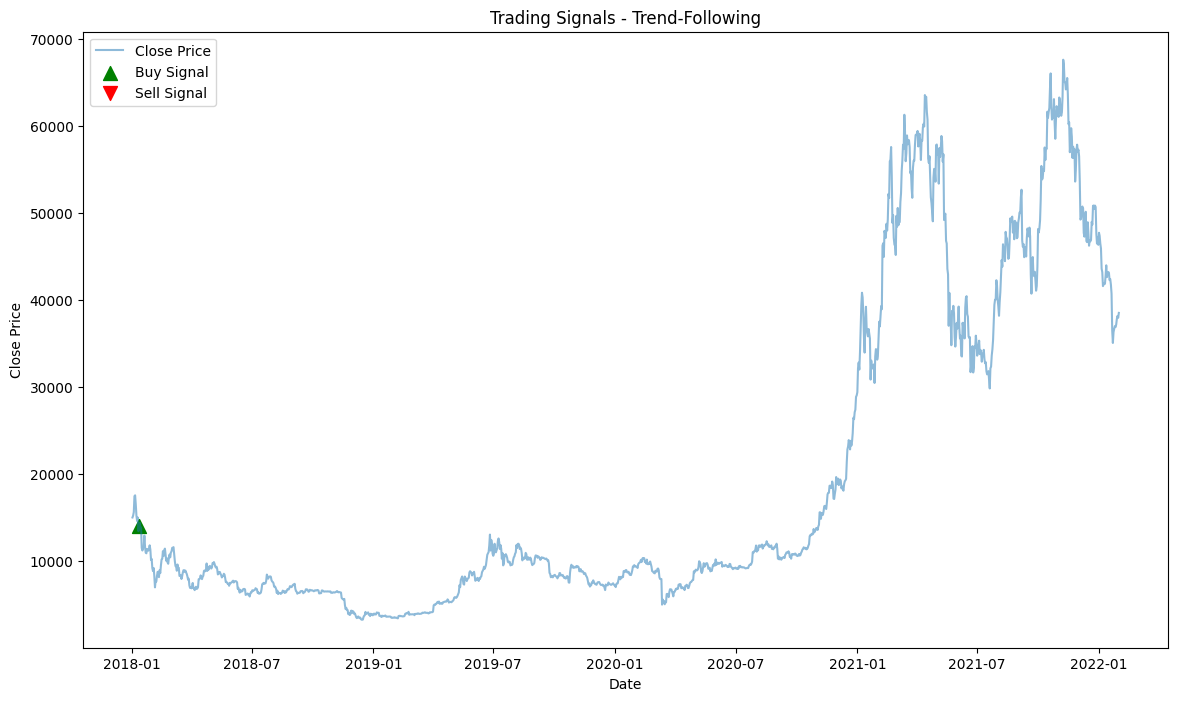

In [ ]:
# Visualize Strategy
def visualize_strategy(data, df1, strategy_name):
    plt.figure(figsize=(14, 8))
    plt.plot(data['Close'], label='Close Price', alpha=0.5)

    # Plot buy signals
    buy_signals = df1[df1['positions'] == 1].index
    plt.scatter(buy_signals, data.loc[buy_signals, 'Close'],
                marker='^', color='g', label='Buy Signal', s=100)

    # Plot sell signals
    sell_signals = df1[df1['positions'] == -1].index
    plt.scatter(sell_signals, data.loc[sell_signals, 'Close'],
                marker='v', color='r', label='Sell Signal', s=100)

    plt.title(f'Trading Signals - {strategy_name}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# Backtest and Analyze Trend-Following Strategy
signals_trend_following = trend_strategy(btcdata)
btcdata_backtest_trend_following, trend_following_annual_returns, trend_following_drawdown = backtest_strategy(btcdata, signals_trend_following, transaction_cost_rate, slippage)
visualize_strategy(btcdata, signals_trend_following, 'Trend-Following')

Annual Returns: 17.43%
Maximum Drawdown: -0.00%



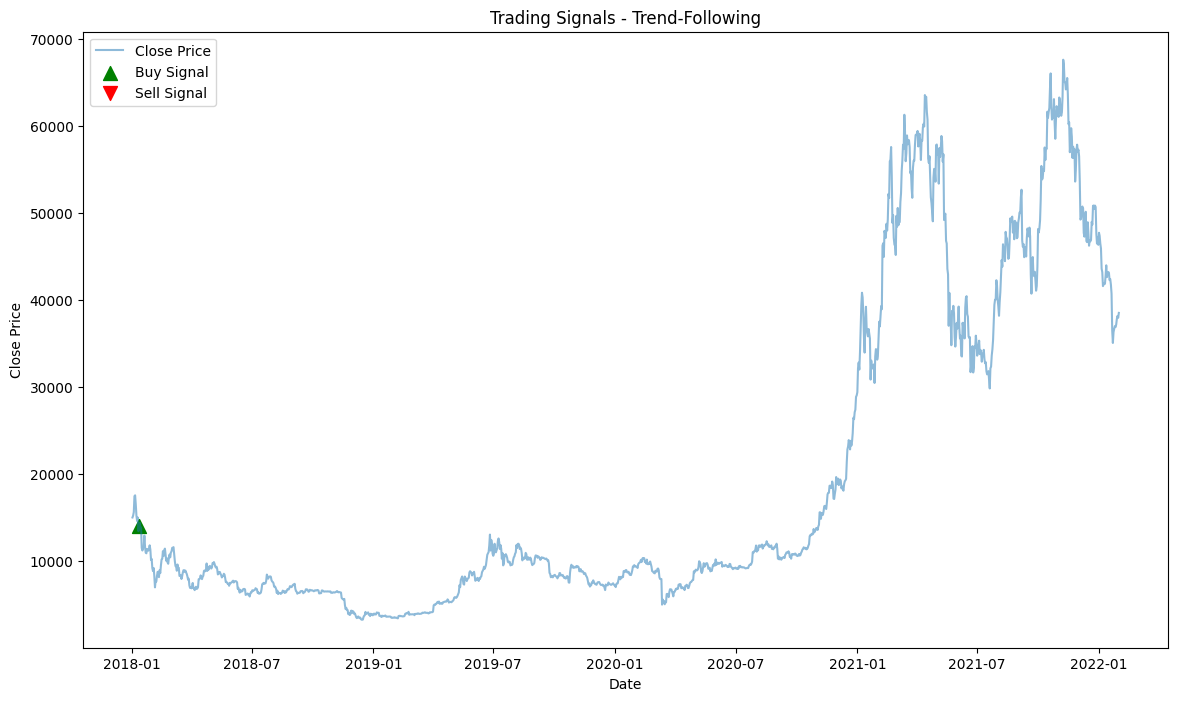

In [ ]:
# Backtest and Analyze Each Strategy
signals_trend_following = trend_strategy(btcdata)
btcdata_backtest_trend_following, trend_following_annual_returns, trend_following_drawdown = backtest_strategy(btcdata, signals_trend_following, transaction_cost_rate, slippage)
visualize_strategy(btcdata, signals_trend_following, 'Trend-Following')

Annual Returns: 0.05%
Maximum Drawdown: 34.22%



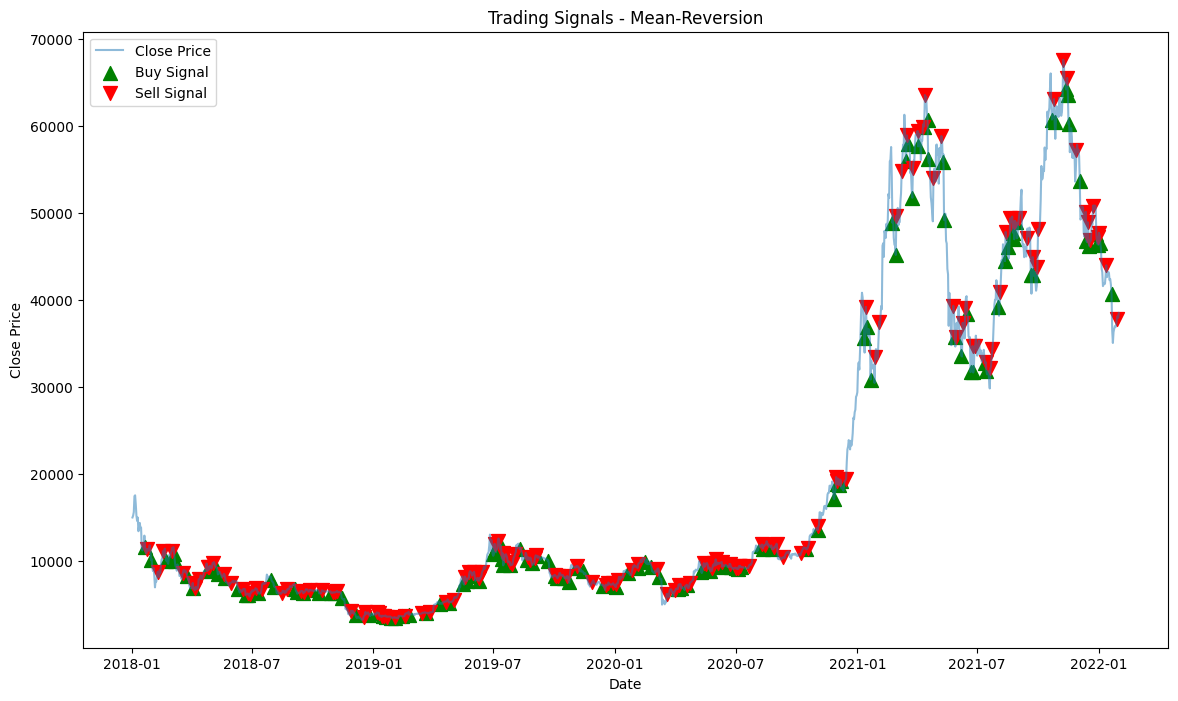

In [ ]:
signals_mean_reversion = meanreversion_strategy(btcdata)
btcdata_backtest_mean_reversion, mean_reversion_annual_returns, mean_reversion_drawdown = backtest_strategy(btcdata, signals_mean_reversion, transaction_cost_rate, slippage)
visualize_strategy(btcdata, signals_mean_reversion, 'Mean-Reversion')

Annual Returns: -2.05%
Maximum Drawdown: 11.56%



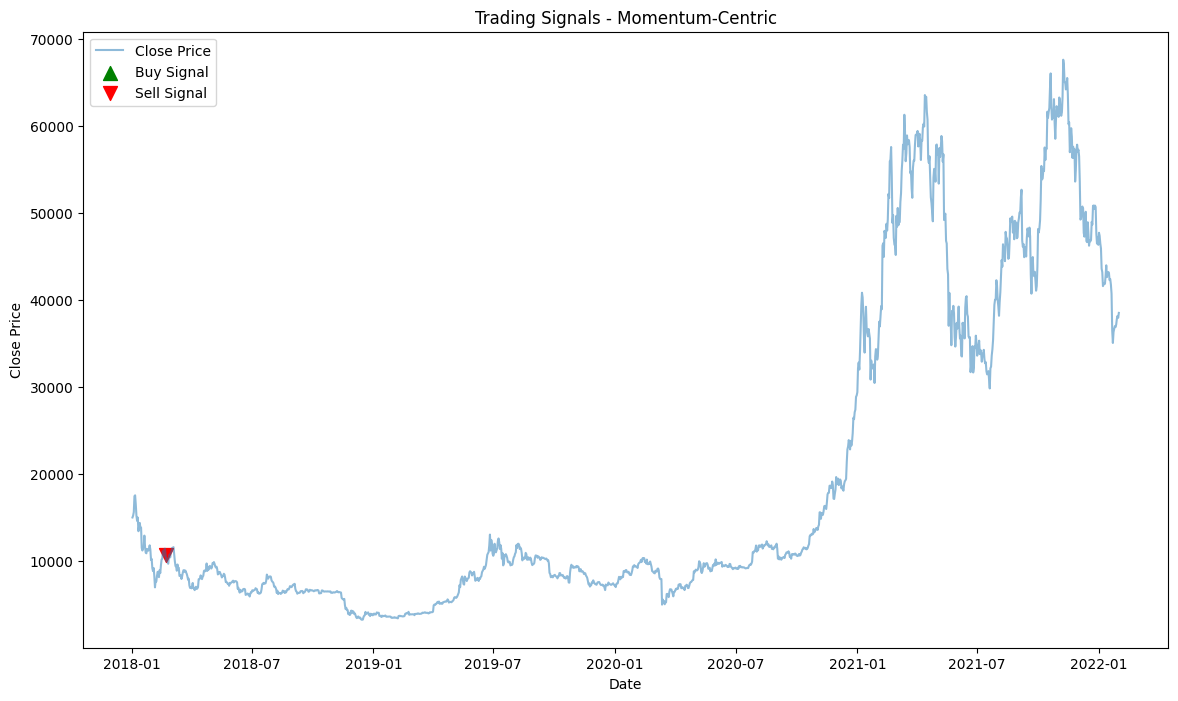

In [ ]:
# Backtest and Analyze Momentum-Centric Strategy
signals_momentum_centric = momentumcentric_strategy(btcdata)
btc_data_backtest_momentum_centric, momentum_centric_annual_returns, momentum_centric_drawdown = backtest_strategy(btcdata, signals_momentum_centric, transaction_cost_rate, slippage)
visualize_strategy(btcdata, signals_momentum_centric, 'Momentum-Centric')

Training Accuracy: 100.00%
Test Accuracy: 99.09%
Annual Returns: -19.35%
Maximum Drawdown: 62.82%



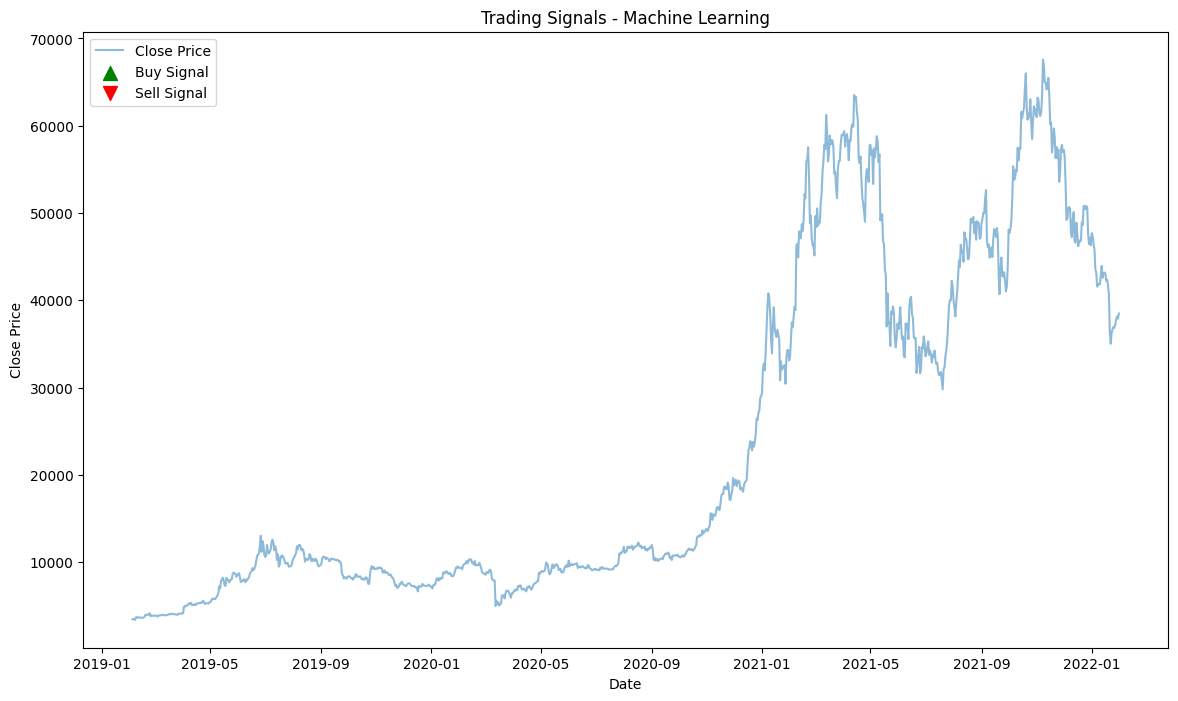

In [ ]:
# Backtest and Analyze Machine Learning Strategy
signals_machine_learning = machinelearning_strategy(btcdata)
btc_data_backtest_machine_learning, machine_learning_annual_returns, machine_learning_drawdown = backtest_strategy(btcdata, signals_machine_learning, transaction_cost_rate, slippage)
visualize_strategy(btcdata, signals_machine_learning, 'Machine Learning')

In [ ]:
#code for risk management


In [ ]:
# Load  dataset
dataset_path = '/content/BTC-USD.csv'  # Replace with the path to your dataset
btcdata = pd.read_csv(dataset_path, parse_dates=True, index_col='Date')
btcdata

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072
...,...,...,...,...,...,...
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,37138.234375,25041426629
2022-01-28,37128.445313,37952.878906,36211.109375,37784.332031,37784.332031,22238830523
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,38138.179688,17194183075


Additional Metrics:
Gross Profit: 0.0
Net Profit: Date
2018-01-01   -0.104686
2018-01-02   -0.104686
2018-01-03   -0.104686
2018-01-04   -0.104686
2018-01-05   -0.104686
                ...   
2022-01-27   -0.104686
2022-01-28   -0.104686
2022-01-29   -0.104686
2022-01-30   -0.104686
2022-01-31   -0.104686
Name: net_profit, Length: 1492, dtype: float64
Total Closed Trades: Date
2018-01-01    1
2018-01-02    1
2018-01-03    1
2018-01-04    1
2018-01-05    1
             ..
2022-01-27    1
2022-01-28    1
2022-01-29    1
2022-01-30    1
2022-01-31    1
Name: total_closed_trades, Length: 1492, dtype: int64
Win Rate: 0.00%
Max Drawdown: 76.30%
Average Winning Trade: Date
2018-01-01    0.0
2018-01-02    0.0
2018-01-03    0.0
2018-01-04    0.0
2018-01-05    0.0
             ... 
2022-01-27    0.0
2022-01-28    0.0
2022-01-29    0.0
2022-01-30    0.0
2022-01-31    0.0
Name: average_winning_trade, Length: 1492, dtype: float64
Average Losing Trade: Date
2018-01-01   -0.00007
2018-01-02   -0.000

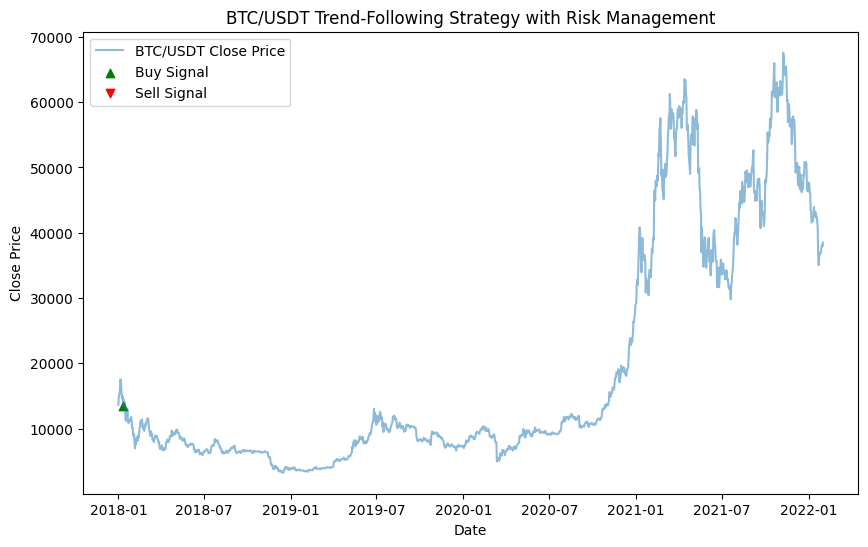

In [ ]:
# Function to implement trend-following strategy with risk management
def trend_followingstrategy_with_risk_management(df, short_window=10, long_window=50, risk_per_trade=0.05):
    df1 = pd.DataFrame(index=df.index)
    df1['signal'] = 0.0

    # Create short simple moving average
    df1['short_mavg'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

    # Create long simple moving average
    df1['long_mavg'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    # Generate signals based on moving average crossover
    df1['signal'][short_window:] = np.where(df1['short_mavg'][short_window:] > df1['long_mavg'][short_window:], 1.0, -1.0)

    # Generate trading orders
    df1['positions'] = df1['signal'].diff()

    # Implement Risk Management
    capital = 100000  # Initial capital in USDT
    position = 0  # Initial position

    df['returns'] = df['Close'].pct_change()

    df['positions'] = df1['positions']

    stop_loss_triggered = False

    for i in range(1, len(df)):
        try:
            if df['positions'][i - 1] == 1:  # Long position
                if not stop_loss_triggered and df['Close'][i] <= df['Close'][i - 1] * (1 - risk_per_trade):
                    df['positions'][i] = 0  # Exit the position
                    stop_loss_triggered = True
                elif stop_loss_triggered:
                    df['positions'][i] = 0  # Exit the position if stop-loss is triggered
        except KeyError:
            pass  # Ignore KeyError

    # Calculate additional metrics
    df['cumulative_returns'] = (1 + df['returns']).cumprod() - 1
    df['gross_profit'] = np.where((df['returns'] > 0) & (df['positions'] == 1), df['returns'], 0)
    df['gross_loss'] = np.where((df['returns'] < 0) & (df['positions'] == 1), df['returns'], 0)
    df['net_profit'] = df['gross_profit'].sum() + df['gross_loss'].sum()
    df['total_closed_trades'] = df['positions'].eq(1).sum()
    df['win_rate'] = df['gross_profit'].gt(0).sum() / df['total_closed_trades']
    df['max_drawdown'] = -df['cumulative_returns'].min()
    df['average_winning_trade'] = df['gross_profit'].mean()
    df['average_losing_trade'] = df['gross_loss'].mean()
    df['buy_and_hold_return'] = (1 + df['returns']).prod() - 1
    df['largest_losing_trade'] = df['gross_loss'].min()
    df['largest_winning_trade'] = df['gross_profit'].max()
    df['sharpe_ratio'] = (df['returns'].mean() / df['returns'].std()) * np.sqrt(252)
    df['sortino_ratio'] = (df['returns'].mean() / df['returns'].loc[df['returns'] < 0].std()) * np.sqrt(252)
    df['average_holding_duration'] = df['positions'].eq(1).sum() / df['total_closed_trades']

    # Print additional metrics
    print("Additional Metrics:")
    print(f'Gross Profit: {df["gross_profit"].sum()}')
    print(f'Net Profit: {df["net_profit"]}')
    print(f'Total Closed Trades: {df["total_closed_trades"]}')
    print('Win Rate: {:.2f}%'.format(df["win_rate"].iloc[0] * 100))
    print('Max Drawdown: {:.2f}%'.format(df["max_drawdown"].iloc[0] * 100))


    print(f'Average Winning Trade: {df["average_winning_trade"]}')
    print(f'Average Losing Trade: {df["average_losing_trade"]}')
    print('Buy and Hold Return of BTC: {:.2f}%'.format(df["buy_and_hold_return"].iloc[0] * 100))


    print(f'Largest Losing Trade: {df["largest_losing_trade"]}')
    print(f'Largest Winning Trade: {df["largest_winning_trade"]}')
    print(f'Sharpe Ratio: {df["sharpe_ratio"]}')
    print(f'Sortino Ratio: {df["sortino_ratio"]}')
    print(f'Average Holding Duration per Trade: {df["average_holding_duration"]}\n')
    print(df)
    print(df.columns)

    return df

# Backtest and analyze the trend-following strategy with risk management
btc_data_backtest = trend_followingstrategy_with_risk_management(btcdata)

# Visualize the results (you may need to modify this based on your preferred visualization library)
plt.figure(figsize=(10, 6))
plt.plot(btcdata['Close'], label='BTC/USDT Close Price', alpha=0.5)
buy_signals = btc_data_backtest.index[btc_data_backtest['positions'] == 1.0]
sell_signals = btc_data_backtest.index[btc_data_backtest['positions'] == -1.0]

plt.scatter(buy_signals, btc_data_backtest['Close'][btc_data_backtest['positions'] == 1.0], label='Buy Signal', marker='^', color='g')
plt.scatter(sell_signals, btc_data_backtest['Close'][btc_data_backtest['positions'] == -1.0], label='Sell Signal', marker='v', color='r')

plt.title('BTC/USDT Trend-Following Strategy with Risk Management')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
#with new featurs
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def machinelearning_strategy_with_new_features(df, short_window=10, long_window=50):
    # Create short simple moving average
    df['short_mavg'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

    # Create long simple moving average
    df['long_mavg'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    # Generate signals based on moving average crossover
    df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1, -1)

    df.dropna(inplace=True)

    X = df[['short_mavg', 'long_mavg', 'returns']]  # Add other features as needed
    y = df['signal']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)

    df1 = pd.DataFrame(index=X_test.index)
    df1['signal'] = np.where(y_pred == 1, 1.0, -1.0)

    df1['positions'] = df1['signal'].diff()

    # Evaluate the model on the training set
    training_accuracy = accuracy_score(y_train, clf.predict(X_train_scaled))
    print(f"Training Accuracy: {training_accuracy:.2%}")

    # Evaluate the model on the test set
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.2%}")

    return df1




Training Accuracy: 100.00%
Test Accuracy: 94.63%
Annual Returns: -9.16%
Maximum Drawdown: 62.68%



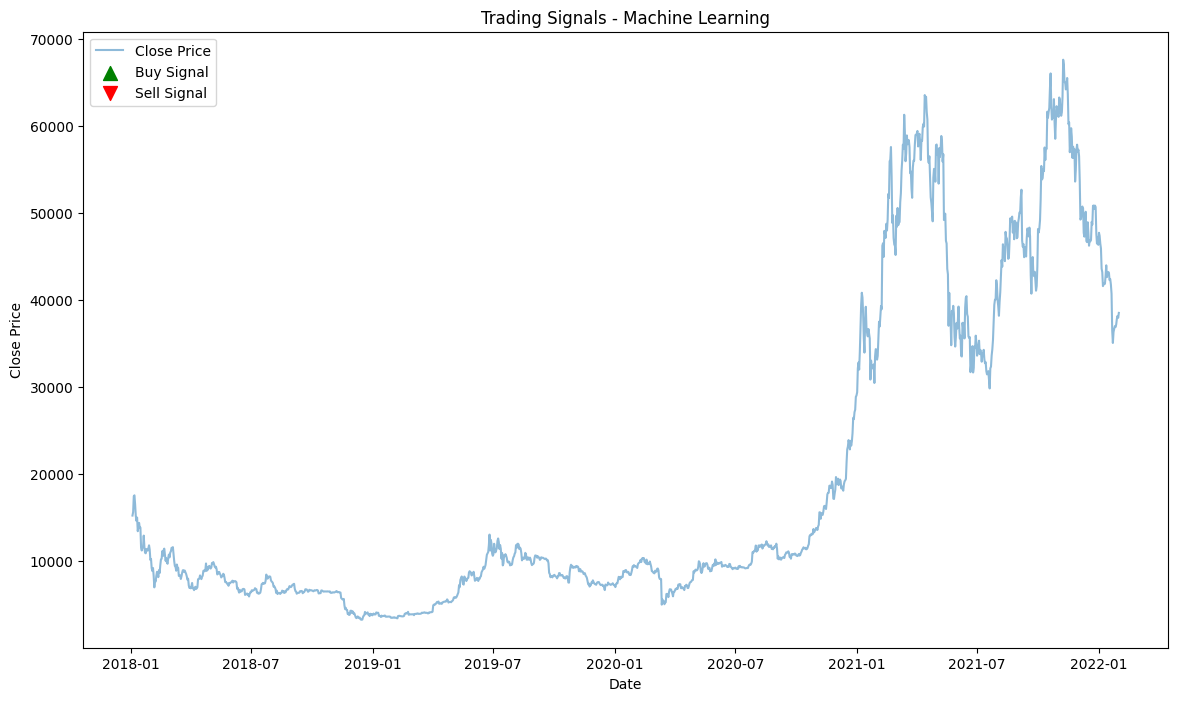

In [ ]:

# Backtest and Analyze Machine Learning Strategy
df1_machine_learning =  machinelearning_strategy_with_new_features(btcdata)
btc_data_backtest_machine_learning, machine_learning_annual_returns, machine_learning_drawdown = backtest_strategy(btcdata, df1_machine_learning, transaction_cost_rate, slippage)
visualize_strategy(btcdata, signals_machine_learning, 'Machine Learning')

In [ ]:
def meanreversion_strategy_with_new_features(df, lookback_period=30, z_score_threshold=1.0, short_window=10, long_window=50):
    df1 = pd.DataFrame(index=df.index)
    df1['signal'] = 0.0

    # Create short simple moving average
    df['short_mavg'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

    # Create long simple moving average
    df['long_mavg'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    # Calculate the rolling mean and standard deviation
    rolling_mean = df['Close'].rolling(window=lookback_period).mean()
    rolling_std = df['Close'].rolling(window=lookback_period).std()

    # Calculate z-score
    z_score = (df['Close'] - rolling_mean) / rolling_std

    # Generate signals based on z-score and moving average crossover
    df1['signal'][z_score < -z_score_threshold] = 1.0
    df1['signal'][z_score > z_score_threshold] = -1.0
    df1['signal'][(df['short_mavg'] > df['long_mavg']) & (z_score > -z_score_threshold)] = 0.0

    # Generate trading orders
    df1['positions'] = df1['signal'].diff()

    return df1




Annual Returns: -7.88%
Maximum Drawdown: 51.81%



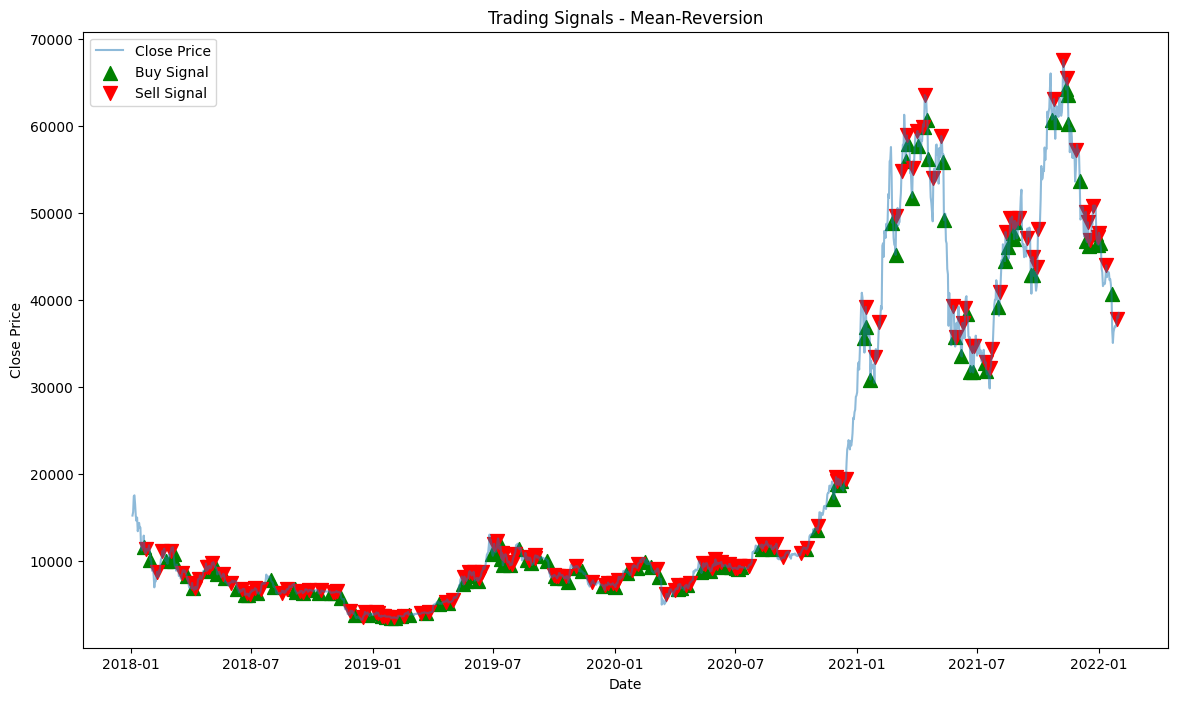

In [ ]:
df1_mean_reversion = meanreversion_strategy_with_new_features(btcdata)
btcdata_backtest_mean_reversion, mean_reversion_annual_returns, mean_reversion_drawdown = backtest_strategy(btcdata, df1_mean_reversion, transaction_cost_rate, slippage)
visualize_strategy(btcdata, signals_mean_reversion, 'Mean-Reversion')

In [ ]:

 def momentumcentric_strateg_ywith_new_features(df, short_window=50, long_window=200):
    df1 = pd.DataFrame(index=df.index)
    df1['signal'] = 0.0

    # Create short simple moving average
    df1['short_mavg'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

    # Create long simple moving average
    df1['long_mavg'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    # Generate signals based on moving average crossover
    df1['signal'][short_window:] = np.where(df1['short_mavg'][short_window:] > df1['long_mavg'][short_window:], 1.0, -1.0)

    # Generate trading orders
    df1['positions'] = df1['signal'].diff()

    return df1

Annual Returns: -3.57%
Maximum Drawdown: 19.34%



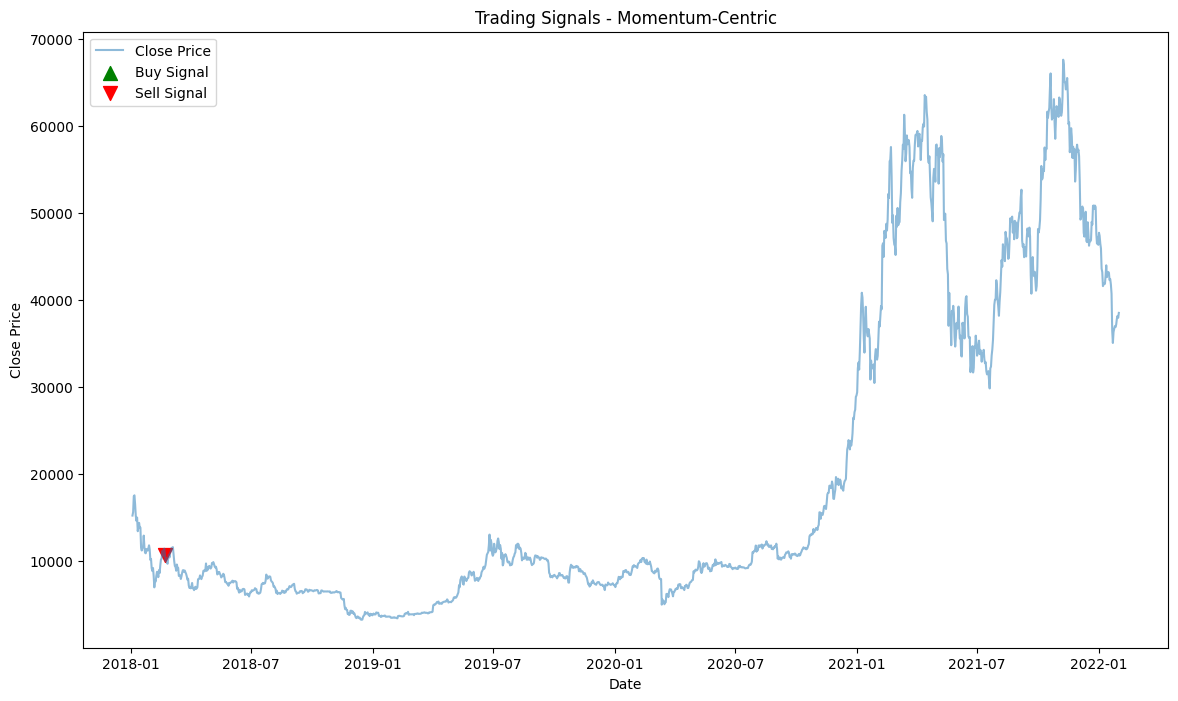

In [ ]:
# Backtest and Analyze Momentum-Centric Strategy
df1_momentum_centric = momentumcentric_strateg_ywith_new_features(btcdata)
btc_data_backtest_momentum_centric, momentum_centric_annual_returns, momentum_centric_drawdown = backtest_strategy(btcdata, df1_momentum_centric, transaction_cost_rate, slippage)
visualize_strategy(btcdata, signals_momentum_centric, 'Momentum-Centric')